In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models

In [49]:
"""
Load overfitting data into a dataloader

"""

# Master path to overfitting data - change this to train/validate/test if needed
master_path = '../Data/ProcessedData/overfit/'
overfitting_dataset = torchvision.datasets.DatasetFolder(master_path, loader=torch.load, extensions=('.tensor'))

# Need to set batch size to 1 before passing into resnet
batch_size = 1
num_workers = 1
overfitting_loader = torch.utils.data.DataLoader(overfitting_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)


In [50]:
"""
Compute features for all images in the dataloader 
Save features into a separate folder

""" 

import os

resnet50 = models.resnet50()
features = resnet50(img.float())

# Path to save features
feature_path = '../Model/features/overfit' # change the last part to train/validate/test if needed

classes = ['0', '1', '2', '3', '4', '5', '6']


# Save features to folder as tensors
n = 0
for img, label in overfitting_loader:
      features = resnet50(img.float())
      features_tensor = torch.from_numpy(features.detach().numpy())
      folder_name = feature_path + '/' + str(classes[label])
      if not os.path.isdir(folder_name):
            os.mkdir(folder_name)
      torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
      n += 1

In [78]:
"""
Finally, load the features into a dataloader with whatever batch size you choose

"""

features_dataset = torchvision.datasets.DatasetFolder(feature_path, loader=torch.load, extensions=('.tensor'))

# Need to set batch size to 1 before passing into resnet
batch_size = 21
num_workers = 1
features_loader = torch.utils.data.DataLoader(features_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)


In [79]:
dataiter = iter(features_loader)
feats, labels = dataiter.next()
print(feats.shape)
print(labels.shape)
print(type(feats))

torch.Size([21, 1000])
torch.Size([21])
<class 'torch.Tensor'>


In [80]:
class EmotionClassifier(nn.Module):
    def __init__(self):
        super(EmotionClassifier, self).__init__()
        self.name = 'emotion_classifier'
        self.fc1 = nn.Linear(1000, 100)
        self.fc2 = nn.Linear(100, 7)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        # assuming we're going to use CrossEntropyLoss, we don't need softmax here
        return x

In [81]:
"""
Get accuracy function

"""

def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for feats, labels in data_loader:
        output = model(feats)
        
        # select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += feats.shape[0]
    return correct / total

In [82]:
def normalize_label(labels):
    """
    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val).float()
    return norm_labels

In [83]:
def get_loss(net, loader, criterion):
    
    """ Evaluate the network loss over the dataset.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the dataset
         criterion: The loss function
     Returns:
         loss: A scalar for the average loss function over the dataset
    """
    
    total_loss = 0.0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        total_loss += loss.item()
    loss = float(total_loss) / (i + 1)
    return loss

In [89]:
"""
Training function

inputs:
    model = PyTorch nn
    batch_size = batch size of the training and validation loaders
    train_loader, val_loader = training and validation dataloader containing features of the imgs
    num_epochs = # of epochs
    lr = learning rate
    
"""

import matplotlib.pyplot as plt
import time
import torch.optim as optim
import random

def train(model, batch_size, train_loader, val_loader, num_epochs, lr):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr, momentum=0.9)

    iters, train_losses, val_losses, train_acc, val_acc = [], [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time = time.time()
    for epoch in range(num_epochs):
        #mini_b=0
        #mini_batch_correct = 0
        #Mini_batch_total = 0
        for feats, labels in iter(train_loader):
            out = model(feats)            # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            ##### Mini_batch Accuracy ##### We don't compute accuracy on the whole trainig set in every iteration!
            #pred = out.max(1, keepdim=True)[1]
            #mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            #Mini_batch_total = feats.shape[0]
            #train_acc.append((mini_batch_correct / Mini_batch_total))
            ###########################

            # save the current training information
            iters.append(n)
            train_losses.append(float(loss)/batch_size)   # compute *average* loss
            """
            Optional: Instead of the above, use get_loss() function to compute loss on the entire dataset, for both training and validation
            sets. Currently, we are only computing the training loss based on one batch.
            
            """
            train_acc.append(get_accuracy(model, train_loader)) # compute test accuracy
            val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy
            n += 1
            #mini_b += 1
            print("Iteration: ",n,'Train acc: % 6.2f ' % train_acc[-1], 'Val acc: % 6.2f ' % train_acc[-1], 
                  'Train loss: % 6.2f ' % train_losses[-1],'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))

        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))


    end_time= time.time()
    
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, train_losses, label="Training")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Training")
    plt.plot(iters, val_acc, label="Validation")    
    plt.xlabel("Iterations")
    plt.ylabel("Validation Accuracy")
    plt.legend(loc='best')
    plt.show()

    train_acc.append(get_accuracy(model, train_loader))
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))

Iteration:  1 Train acc:   0.19  Val acc:   0.19  Train loss:   0.09  % Time Elapsed:   4.73 s 
Epoch 0 Finished.  Time per Epoch:   4.86 s 
Iteration:  2 Train acc:   0.24  Val acc:   0.24  Train loss:   0.09  % Time Elapsed:   9.90 s 
Epoch 1 Finished.  Time per Epoch:   5.03 s 
Iteration:  3 Train acc:   0.38  Val acc:   0.38  Train loss:   0.09  % Time Elapsed:  14.76 s 
Epoch 2 Finished.  Time per Epoch:   4.96 s 
Iteration:  4 Train acc:   0.43  Val acc:   0.43  Train loss:   0.09  % Time Elapsed:  19.47 s 
Epoch 3 Finished.  Time per Epoch:   4.90 s 
Iteration:  5 Train acc:   0.62  Val acc:   0.62  Train loss:   0.09  % Time Elapsed:  24.12 s 
Epoch 4 Finished.  Time per Epoch:   4.85 s 
Iteration:  6 Train acc:   0.86  Val acc:   0.86  Train loss:   0.09  % Time Elapsed:  28.85 s 
Epoch 5 Finished.  Time per Epoch:   4.83 s 
Iteration:  7 Train acc:   1.00  Val acc:   1.00  Train loss:   0.09  % Time Elapsed:  33.79 s 
Epoch 6 Finished.  Time per Epoch:   4.84 s 
Iteration:  8

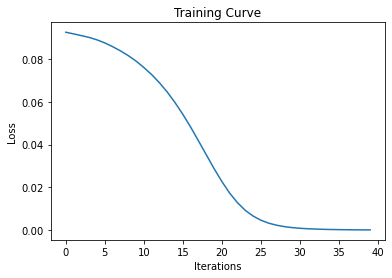

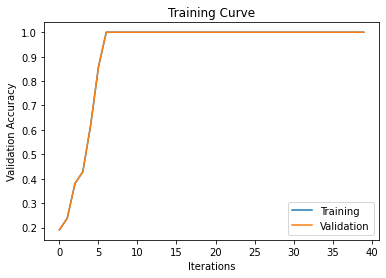

Final Training Accuracy: 1.0
Final Validation Accuracy: 1.0
Total time:   203.17 s  Time per Epoch:   5.08 s 


In [90]:
# Define our NN
network = EmotionClassifier()

# Train our NN
train(model=network, batch_size=21, train_loader=features_loader, val_loader=features_loader, num_epochs=40, lr=5e-2)